Store Sales - Time Series Forecasting
- Demand forecasting

- Ecuador

In [58]:
import numpy as np
import pandas as pd
#import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

from sklearn.linear_model import LinearRegression

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set_theme(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})


In [59]:
# Funções para analisar métricas de erro

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    Erro Percentual Absoluto Médio (MAPE)
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    '''
    Root Mean Squared Error (RMSE) Function
    
    input: list/series for actual values and predicted values
    output: rmse value 
    '''
    return np.sqrt(np.mean((actual - pred) ** 2))

def mae(actual, pred):
    '''
    Mean Absolute Error (MAE) Function
    
    input: list/series for actual values and predicted values
    output: mae value 
    '''
    return np.mean(np.abs(actual - pred))

def list_metrics(actual, pred):
    '''
    This function returns a list with the metrics MAPE, RMSE and MAE
    
    input: list/series for actual values and predicted values
    output: list with MAPE, RMSE and MAE values
    '''
    mape_value = mape(actual, pred)
    rmse_value = rmse(actual, pred)
    mae_value = mae(actual, pred)
    return [mape_value, rmse_value, mae_value]

Lendo os datasets

In [60]:
main_path = "dataset/corporacion-favorit/"
df = pd.read_csv(main_path + "train.csv")
#new_df = pd.read_csv(main_path + "test.csv")


In [61]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.13,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.55,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.73,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.00,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.00,0


In [62]:
len(df)

3000888

In [63]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'])

In [64]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [66]:
# verificando se há valores nulos
df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [67]:
# agregando as vendas por data e por família
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


In [68]:
df.groupby('family')['sales'].sum().sort_values(ascending=False).head(15)

family
GROCERY I          343462734.89
BEVERAGES          216954486.00
PRODUCE            122704684.68
CLEANING            97521289.00
DAIRY               64487709.00
BREAD/BAKERY        42133945.58
POULTRY             31876004.47
MEATS               31086468.40
PERSONAL CARE       24592051.00
DELI                24110322.47
HOME CARE           16022744.00
EGGS                15588296.00
FROZEN FOODS        14073887.72
PREPARED FOODS       8799895.12
LIQUOR,WINE,BEER     7746640.00
Name: sales, dtype: float64

In [69]:
# variavel independente
var_independente = 'BEVERAGES'

In [70]:
# pivot table
df_pivot = df.pivot_table(index='date', columns='family', values='sales', aggfunc='sum').fillna(0)
df_pivot.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


In [71]:
# filtrando o dataset
df_filtered = df_pivot[[var_independente]]

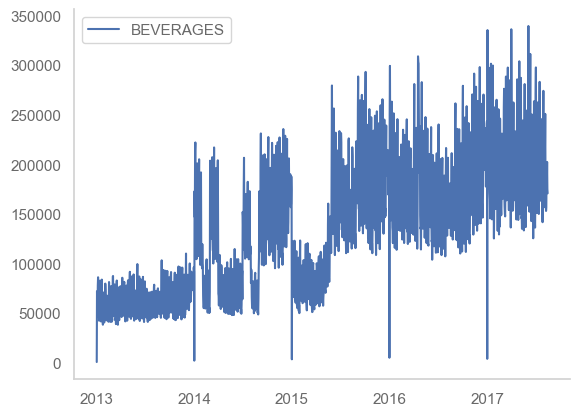

In [72]:
plt.plot(df_filtered)
plt.legend([var_independente])
plt.show()

In [73]:
prediction_days = 30
df = df_pivot[[var_independente]].reset_index()
df.head()

family,date,BEVERAGES
0,2013-01-01,810.00
1,2013-01-02,72092.00
2,2013-01-03,52105.00
3,2013-01-04,54167.00
4,2013-01-05,77818.00


In [74]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict

# n entendi mt bem esse window
for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'])
holiday.head()

,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


Prophet model

$y(t) = g(t) + h(t) + s(t) + et$

In [75]:


forecast_start_dt = '2017-07-01'

#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', var_independente: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_dt) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_dt 
predicted_df = fcst_prophet_train[filter][['ds','y_pred']]

AttributeError: 'Prophet' object has no attribute 'stan_backend'

tilizando Linear Regression

In [95]:
from sklearn.linear_model import LinearRegression
import numpy as np

forecast_start_dt = '2017-06-01'

# Preparo dos dados
df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', var_independente: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
df_copy['ds'] = pd.to_datetime(df_copy['ds'])

# Convertendo datas para números inteiros para a regressão
df_copy['ds_numeric'] = (df_copy['ds'] - df_copy['ds'].min()).dt.days

# Conjunto de treino
train_set = df_copy[(df_copy['ds'] < forecast_start_dt)]

# Regressão Linear
X_train = train_set[['ds_numeric']]
y_train = train_set['y']

model = LinearRegression()
model.fit(X_train, y_train)

# Gerando previsões futuras
prediction_days = (df_copy['ds'].max() - pd.to_datetime(forecast_start_dt)).days
future_dates = pd.date_range(start=forecast_start_dt, periods=prediction_days)
future_numeric = (future_dates - df_copy['ds'].min()).days.values.reshape(-1, 1)

y_pred = model.predict(future_numeric)

# Criação do DataFrame de previsão
predicted_df = pd.DataFrame({
    'ds': future_dates,
    'y_pred': y_pred
})

# Filtrando o DataFrame
predicted_df = predicted_df[predicted_df['ds'] >= pd.to_datetime(forecast_start_dt)]

print(predicted_df.head())


          ds    y_pred
0 2017-06-01 204044.79
1 2017-06-02 204141.89
2 2017-06-03 204238.99
3 2017-06-04 204336.09
4 2017-06-05 204433.19


c:\Users\dorie\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [96]:
df_copy = df.copy()
df_copy.columns = ['ds', 'y_real']
predicted_df = predicted_df.merge(df_copy)

In [97]:
predicted_df.head()

,ds,y_pred,y_real
0,2017-06-01,204044.79,166771.00
1,2017-06-02,204141.89,204402.00
2,2017-06-03,204238.99,278488.00
3,2017-06-04,204336.09,339352.00
4,2017-06-05,204433.19,214773.00


In [99]:
len(predicted_df)

75

In [98]:
erro = mape(predicted_df['y_real'], predicted_df['y_pred'])
acerto = 100 - erro

print(f'A acurácia do modelo é de {acerto:.2f}%')

A acurácia do modelo é de 77.84%
